# Welcome to Rwanda Carbon Prediction

**About the problem**

The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.


**Objective of this project**


The objective of this project is to create machine learning or a deep learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.


These solutions will enable governments and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.

**Tentang masalahnya**

Kemampuan untuk memantau emisi karbon secara akurat merupakan langkah penting dalam perjuangan melawan perubahan iklim. Pembacaan karbon yang tepat memungkinkan para peneliti dan pemerintah memahami sumber dan pola keluaran massa karbon. Meskipun Eropa dan Amerika Utara memiliki sistem ekstensif untuk memantau emisi karbon di lapangan, hanya sedikit sistem yang tersedia di Afrika.

**Tujuan dari project ini**

Tujuan dari project ini adalah untuk membuat pembelajaran mesin atau model pembelajaran mendalam menggunakan data emisi CO2 sumber terbuka (dari pengamatan satelit Sentinel-5P) untuk memprediksi emisi karbon.

Solusi-solusi ini akan memungkinkan pemerintah dan aktor-aktor lain untuk memperkirakan tingkat emisi karbon di seluruh Afrika, bahkan di negara-negara yang pemantauan lapangannya tidak memungkinkan.

In [1]:
!python --version

Python 3.10.12


# 1.&nbsp; Installing and importing libraries

In [2]:
# Install relevant libraries
!pip install geopandas folium
!pip install pystan
!pip install pandas scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.3 MB/s eta 0:00:00


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import RandomizedSearchCV
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# Set seed for reproducability
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 2.&nbsp; Loading and previewing data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load Train set
train = pd.read_csv("/content/drive/MyDrive/FINALPROJECTGE/Copy of train.csv")

# Load Test set
test = pd.read_csv("/content/drive/MyDrive/FINALPROJECTGE/Copy of test.csv")

# Load sample_submission
sample_submission = pd.read_csv ("/content/drive/MyDrive/FINALPROJECTGE/Copy of sample_submission.csv")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      24353 non-null  object 
 1   latitude                                                  24353 non-null  float64
 2   longitude                                                 24353 non-null  float64
 3   year                                                      24353 non-null  int64  
 4   week_no                                                   24353 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  18211 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              18211 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            18211 non-null  float64
 8   SulphurDioxide_c

In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK  24353 non-null  object 
 1   emission              24353 non-null  float64
dtypes: float64(1), object(1)
memory usage: 380.6+ KB


In [10]:
# Checking if column headings are the same in both data set
dif_1 = [x for x in train.columns if x not in test.columns] #
print(f"Columns present in df_train and absent in df_train: {dif_1}\n")

dif_2 = [x for x in test.columns if x not in train.columns]
print(f"Columns present in df_test set and absent in df_test: {dif_2}")

Columns present in df_train and absent in df_train: ['emission']

Columns present in df_test set and absent in df_test: []


In [11]:
# Preview train dataset
train.head(5)

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51000,29.29000,2019,0,-0.00011,0.60302,-0.00007,0.25567,-98.59389,...,3664.43622,61085.80957,2615.12048,15.56853,0.27229,-12.62899,35.63242,-138.78642,30.75214,3.75099
1,ID_-0.510_29.290_2019_01,-0.51000,29.29000,2019,1,0.00002,0.72821,0.00001,0.13099,16.59286,...,3651.19031,66969.47873,3174.57242,8.69060,0.25683,30.35938,39.55763,-145.18393,27.25178,4.02518
2,ID_-0.510_29.290_2019_02,-0.51000,29.29000,2019,2,0.00051,0.74820,0.00038,0.11002,72.79584,...,4216.98649,60068.89445,3516.28267,21.10341,0.25110,15.37788,30.40182,-142.51954,26.19330,4.23138
3,ID_-0.510_29.290_2019_03,-0.51000,29.29000,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.50774,51064.54734,4180.97332,15.38690,0.26204,-11.29340,24.38036,-132.66583,28.82915,4.30529
4,ID_-0.510_29.290_2019_04,-0.51000,29.29000,2019,4,-0.00008,0.67630,-0.00005,0.12116,4.12127,...,3980.59812,63751.12578,3355.71011,8.11469,0.23585,38.53226,37.39298,-141.50981,22.20461,4.34732


In [12]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51000,29.29000,2022,0,NaN,NaN,NaN,NaN,NaN,...,36022.02734,8472.31348,41047.93750,7472.31348,7.93562,0.24077,-100.11379,33.69704,-133.04755,33.77958
1,ID_-0.510_29.290_2022_01,-0.51000,29.29000,2022,1,0.00046,0.69116,0.00032,0.00000,76.23920,...,48539.73724,6476.14732,54915.70858,5476.14716,11.44844,0.29312,-30.51032,42.40259,-138.63282,31.01238
2,ID_-0.510_29.290_2022_02,-0.51000,29.29000,2022,2,0.00016,0.60511,0.00011,0.07987,-42.05534,...,34133.08047,8984.79570,39006.09375,7984.79570,10.75318,0.26713,39.08736,45.93648,-144.78499,26.74336
3,ID_-0.510_29.290_2022_03,-0.51000,29.29000,2022,3,0.00035,0.69692,0.00024,0.20103,72.16957,...,50854.99108,6014.72406,57646.36837,5014.72412,11.76456,0.30468,-24.46513,42.14042,-135.02789,29.60477
4,ID_-0.510_29.290_2022_04,-0.51000,29.29000,2022,4,-0.00032,0.58053,-0.00018,0.20435,76.19086,...,46594.68514,6849.28048,52896.54187,5849.28039,13.06532,0.28422,-12.90785,30.12264,-135.50012,26.27681


In [13]:
# Preview sample_submission file
sample_submission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94000
1,ID_-0.510_29.290_2022_01,81.94000
2,ID_-0.510_29.290_2022_02,81.94000
3,ID_-0.510_29.290_2022_03,81.94000
4,ID_-0.510_29.290_2022_04,81.94000


In [14]:
# Check size and shape of datasets
train.shape, test.shape, sample_submission.shape

((79023, 76), (24353, 75), (24353, 2))

In [15]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.23557692307692307

# 3.&nbsp; Exploratory Data Analyst (EDA) and Data Cleaning

In [16]:
# Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023,79023.00000,79023.00000,79023.00000,79023.00000,64414.00000,64414.00000,64414.00000,64414.00000,64414.00000,...,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,79023.00000
unique,79023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-0.510_29.290_2019_00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-1.89107,29.88015,2020.00000,26.00000,0.00005,0.83485,0.00004,0.15842,-7.92587,...,5592.37748,59420.29746,4670.43087,19.13924,0.27146,-10.78483,40.43698,-86.80058,27.92598,81.94055
std,NaN,0.69452,0.81038,0.81650,15.29716,0.00027,0.18538,0.00021,0.07136,64.26337,...,1428.50300,9051.16361,1359.25158,13.54705,0.04943,30.37446,6.42822,37.83727,4.40384,144.29965
min,NaN,-3.29900,28.22800,2019.00000,0.00000,-0.00100,0.24182,-0.00089,0.00000,-179.53706,...,1050.66178,24779.03370,1050.49682,1.84453,0.01770,-102.73973,2.99887,-153.46421,10.81829,0.00000
25%,NaN,-2.45100,29.26200,2019.00000,13.00000,-0.00010,0.70582,-0.00008,0.11053,-56.78238,...,4595.40052,53175.77993,3680.85634,9.97457,0.24145,-30.30917,35.82991,-125.99116,24.68676,9.79800
50%,NaN,-1.88200,29.88300,2020.00000,26.00000,0.00002,0.80912,0.00002,0.16185,-12.44173,...,5573.85431,59332.53255,4621.75517,15.13069,0.27275,-12.67391,41.11963,-84.64435,28.33363,45.59345
75%,NaN,-1.30300,30.47100,2021.00000,39.00000,0.00015,0.94279,0.00012,0.21182,72.05999,...,6542.30364,65663.84268,5572.98322,23.78503,0.30289,9.40220,44.44627,-48.13270,31.49988,109.54959


Dari ringkasan statistik di atas, kita dapat menyimpulkan beberapa wawasan berikut:
*   Data pelatihan yang disediakan berkisar dari tahun 2019 hingga 2021
*   Emisi CO2 minimum yang tercatat adalah 0,000 dan maksimum 3167,76800
*   Minggu dalam setahun dimulai dari 0 hingga 52
*   Rentang garis lintang (latitude) dan garis bujur (longitude) menunjukkan bahwa wilayah tersebut sebagian besar berada di Rwanda

## 3.1.&nbsp; Missing Values and Duplicates

In [17]:
# Check for missing values
train.isnull().sum().any(),
test.isnull().sum().any()

True

Train dan test sama sama memiliki nilai NaN atau hilang

### A. Train Set

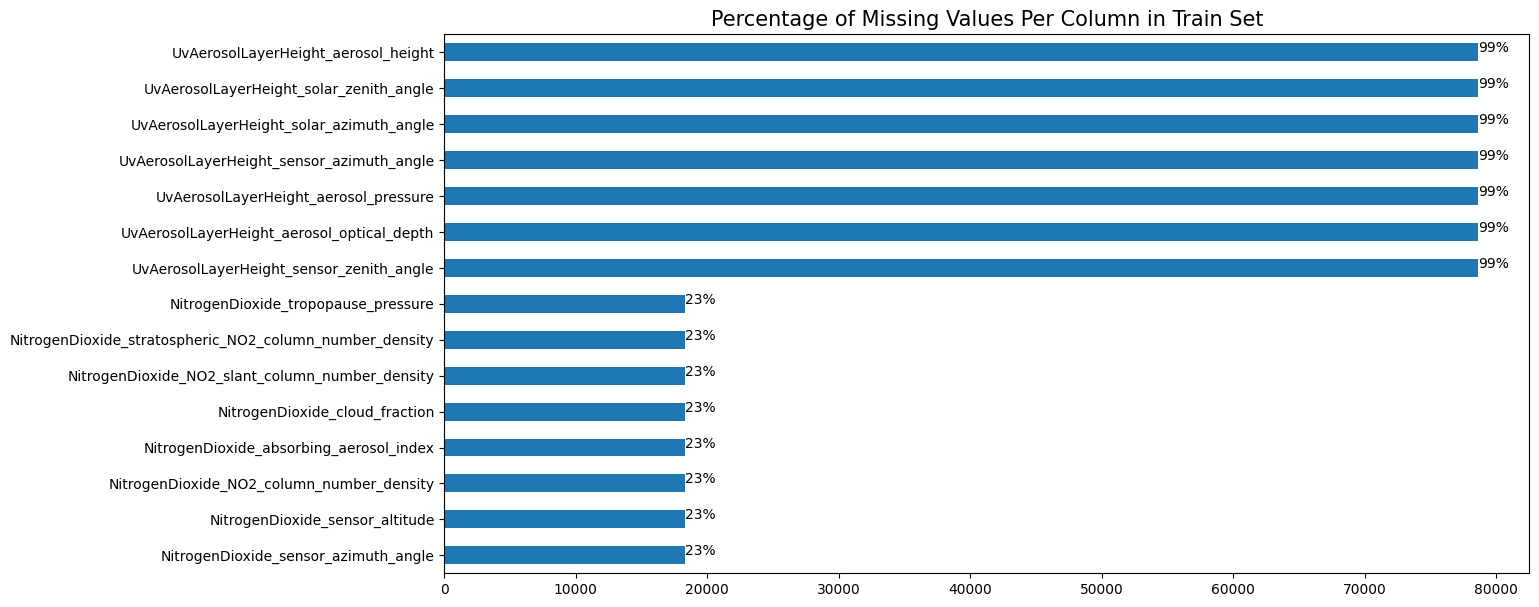

In [18]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (14, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [19]:
# Calculating Missing Value interms of Percentage

missing_value_percentage = (train.isnull().sum() / len(train))*100
missing_value_percentage.sort_values(ascending=False)

,0
UvAerosolLayerHeight_aerosol_height,99.44447
UvAerosolLayerHeight_solar_zenith_angle,99.44447
UvAerosolLayerHeight_solar_azimuth_angle,99.44447
UvAerosolLayerHeight_sensor_azimuth_angle,99.44447
UvAerosolLayerHeight_aerosol_pressure,99.44447
UvAerosolLayerHeight_aerosol_optical_depth,99.44447
UvAerosolLayerHeight_sensor_zenith_angle,99.44447
NitrogenDioxide_tropopause_pressure,23.18312
NitrogenDioxide_stratospheric_NO2_column_number_density,23.18312
NitrogenDioxide_NO2_slant_column_number_density,23.18312


### B. Test Set

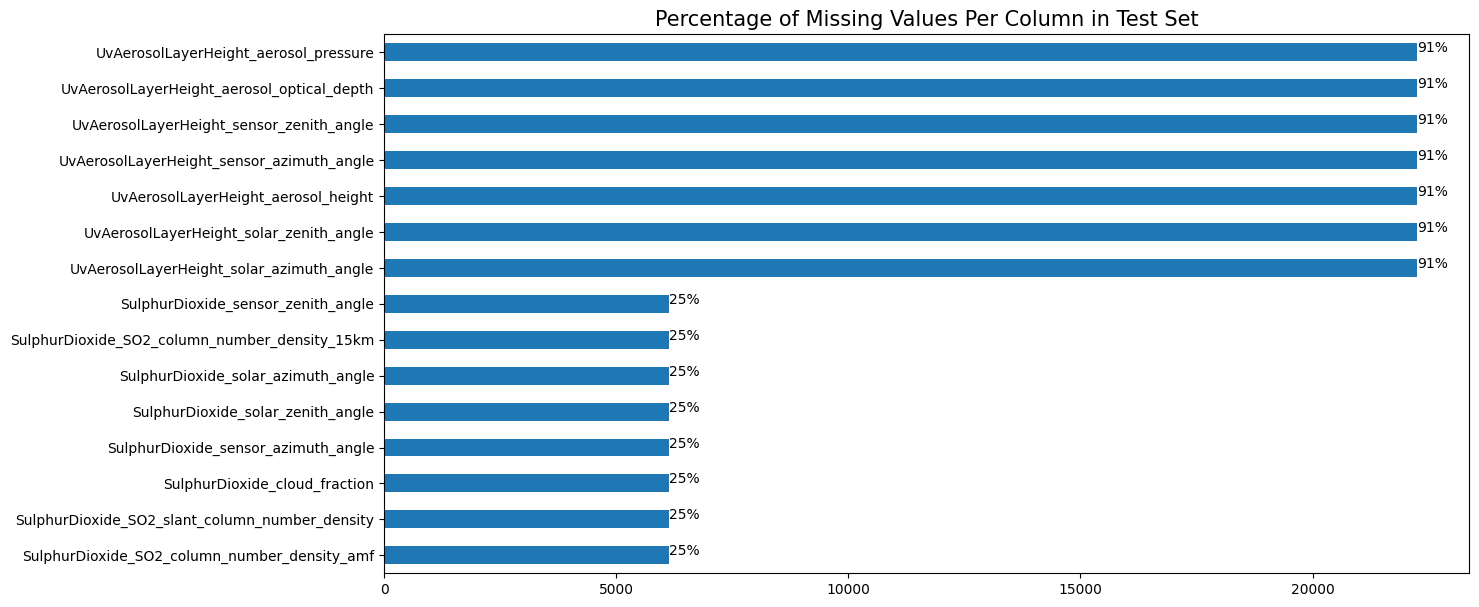

In [20]:
# Plot missing values in test set
ax = test.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (14, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [21]:
test_missing_value_percentage = (test.isnull().sum() / len(test))*100
test_missing_value_percentage.sort_values(ascending=False)

,0
UvAerosolLayerHeight_aerosol_pressure,91.40558
UvAerosolLayerHeight_aerosol_optical_depth,91.40558
UvAerosolLayerHeight_sensor_zenith_angle,91.40558
UvAerosolLayerHeight_sensor_azimuth_angle,91.40558
UvAerosolLayerHeight_aerosol_height,91.40558
UvAerosolLayerHeight_solar_zenith_angle,91.40558
UvAerosolLayerHeight_solar_azimuth_angle,91.40558
SulphurDioxide_sensor_zenith_angle,25.22071
SulphurDioxide_SO2_column_number_density_15km,25.22071
SulphurDioxide_solar_azimuth_angle,25.22071


### C. Drop and Replace Missing Value

In [22]:
# Menghapus Kolom yang memiliki persentasi missing value lebih besar dari 60 persen
columns_to_drop = missing_value_percentage[missing_value_percentage > 60].index
train_clean = train.drop(columns=columns_to_drop)
test_clean = test.drop(columns=columns_to_drop)

In [ ]:
# Mengisi Kolom yang memiliki persentasi missing value antara >10 persen sampai <60 persen

from sklearn.impute import KNNImputer

# Select columns to impute using KNN
columns_to_knn = missing_value_percentage[(missing_value_percentage > 10) & (missing_value_percentage < 60)].index

# KNN Imputation for selected columns
Knn_impu = KNNImputer(n_neighbors=5)
train_clean[columns_to_knn] = Knn_impu.fit_transform(train_clean[columns_to_knn])
test_clean[columns_to_knn] = Knn_impu.fit_transform(test_clean[columns_to_knn])

# Now you can use the 'columns_to_knn' variable if needed
print(train_clean[columns_to_knn])
print(test_clean[columns_to_knn])

In [24]:
# Mengisi Kolom yang memiliki persentasi missing value dibawah 10 persen dengan mean
columns_to_mean=missing_value_percentage[ (missing_value_percentage <10) & (missing_value_percentage >0)].index
columns_mean_train = train_clean[columns_to_mean].mean()
columns_mean_test = test_clean[columns_to_mean].mean()
train_clean[columns_to_mean] = train_clean[columns_to_mean].fillna(columns_mean_train)
test_clean[columns_to_mean] = test_clean[columns_to_mean].fillna(columns_mean_test)

In [25]:
train_clean.isnull().sum(), train_clean.isnull().sum()

(ID_LAT_LON_YEAR_WEEK                                        0
 latitude                                                    0
 longitude                                                   0
 year                                                        0
 week_no                                                     0
 SulphurDioxide_SO2_column_number_density                    0
 SulphurDioxide_SO2_column_number_density_amf                0
 SulphurDioxide_SO2_slant_column_number_density              0
 SulphurDioxide_cloud_fraction                               0
 SulphurDioxide_sensor_azimuth_angle                         0
 SulphurDioxide_sensor_zenith_angle                          0
 SulphurDioxide_solar_azimuth_angle                          0
 SulphurDioxide_solar_zenith_angle                           0
 SulphurDioxide_SO2_column_number_density_15km               0
 CarbonMonoxide_CO_column_number_density                     0
 CarbonMonoxide_H2O_column_number_density              

## 3.2.&nbsp; Target Variable (Emission) Visualization

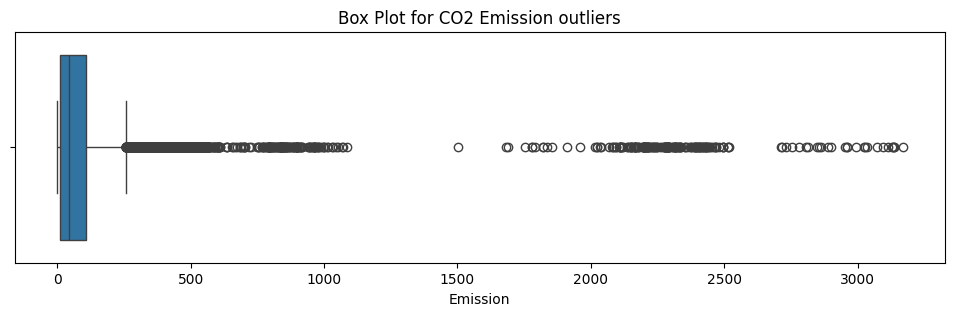

In [27]:
# Plot vertical box plot
plt.figure(figsize=(12,3))
sns.boxplot(x=train_clean['emission'])
plt.title('Box Plot for CO2 Emission outliers')
plt.xlabel('Emission')
plt.show()

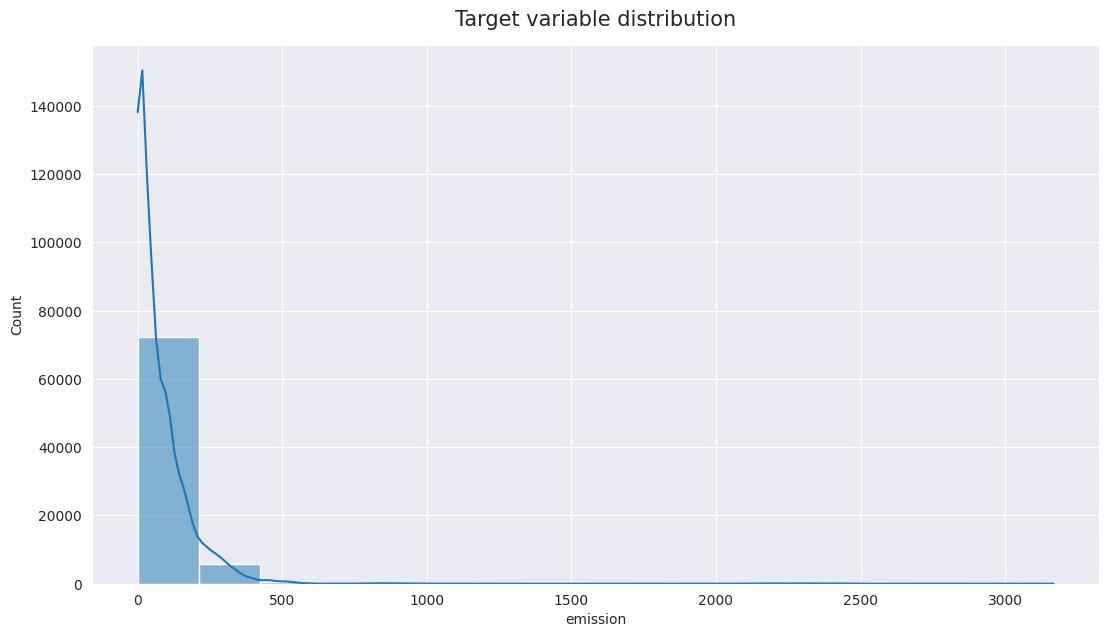

None

10.173825825101622

In [28]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train_clean.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train_clean.emission.skew())

## 3.3.&nbsp; Geo Visualization

In [29]:
geo_mean_emission = train_clean.groupby(["latitude", "longitude"]).emission.mean().reset_index()
zero_emission = geo_mean_emission[geo_mean_emission.emission == 0]

fig = px.scatter_mapbox(
    geo_mean_emission,
    lat="latitude",
    lon="longitude",
    color="emission",
    size="emission",
    color_continuous_scale=px.colors.sequential.Cividis,
    size_max=30,
    zoom=7,
    width=840,
    height=940,
    title="Distinct Locations of Data Collection in Rwanda<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Each dot is associated with the mean CO\u2082 emission collected for this place</span>",
)
fig.add_scattermapbox(
    lat=zero_emission.latitude,
    lon=zero_emission.longitude,
    name="Zero-Emission",
    marker=dict(color="#228B22", size=15, symbol="circle", opacity=0.75),
)
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(r=0, t=90, l=0, b=0),
    font_color="#4A4B52",
    title_font_size=18,
    coloraxis_colorbar=dict(
        title="Mean Emission",
        title_side="top",
        orientation="h",
        yanchor="bottom",
        xanchor="center",
        y=-0.13,
        x=0.5,
    ),
    legend=dict(yanchor="bottom", xanchor="right", y=1, x=1, orientation="h"),
    plot_bgcolor="#FFFCFA",
    paper_bgcolor="#FFFCFA",
)
fig.show()

## 3.4. &nbsp; Year Count Plot

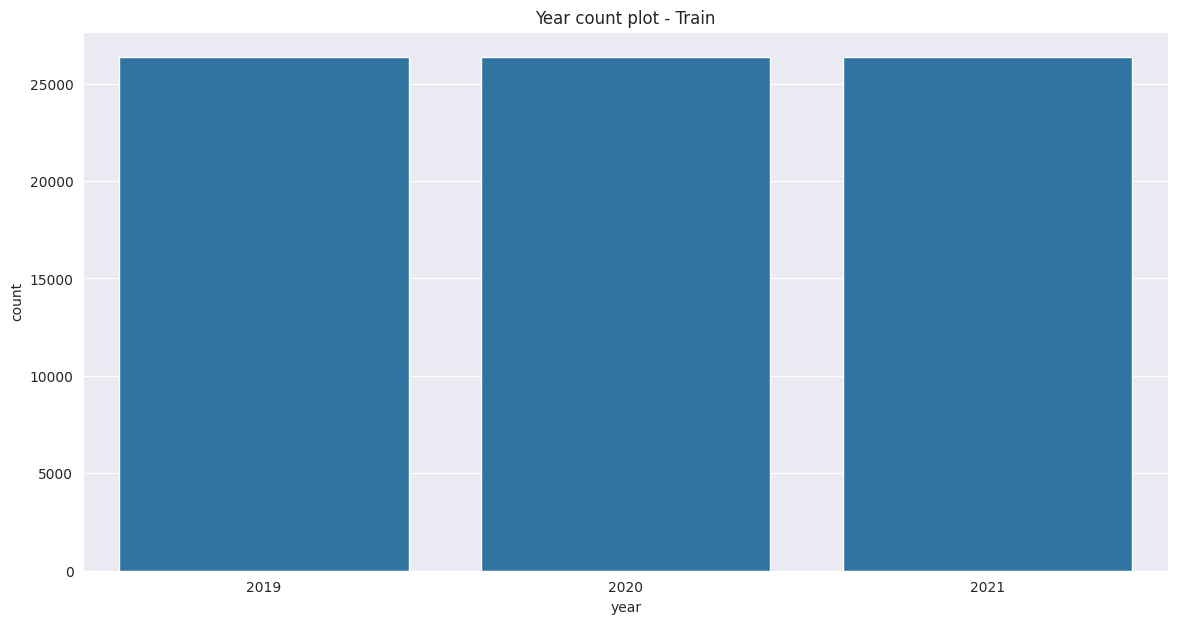

In [30]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train_clean)
plt.title('Year count plot - Train')
plt.show()

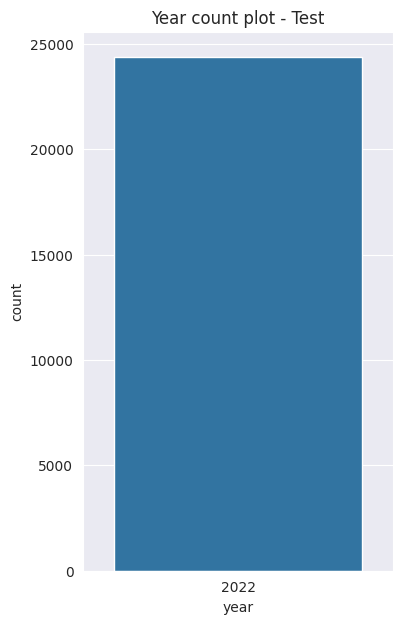

In [31]:
# Year countplot
plt.figure(figsize = (4, 7))
sns.countplot(x = 'year', data = test_clean)
plt.title('Year count plot - Test')
plt.show()

- The number of observations of CO2 emissions are the same across the years (2019, 2020, 2021)
- Year 2022 (in the test set) has fewer number of observations

## 3.5. &nbsp; Week Count Plot

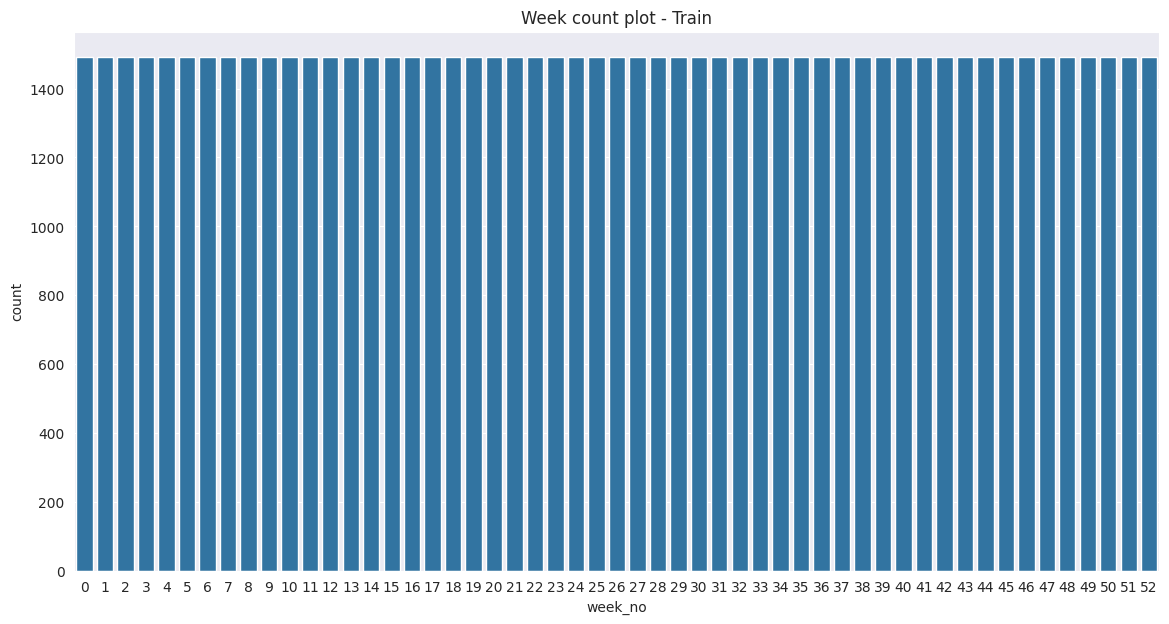

In [32]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train_clean)
plt.title('Week count plot - Train')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the weeks

## 3.6. &nbsp; Correlations

In [33]:
# Mengidentifikasi kolom/fitur numerik
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns

# Top 20 correlated features to the target
top20_corrs = abs(train[numeric_cols].corr()['emission']).sort_values(ascending=False).head(20)
top20_corrs

,emission
emission,1.00000
longitude,0.10275
UvAerosolLayerHeight_aerosol_height,0.06901
UvAerosolLayerHeight_aerosol_pressure,0.06814
Cloud_surface_albedo,0.04659
CarbonMonoxide_H2O_column_number_density,0.04322
CarbonMonoxide_CO_column_number_density,0.04133
Formaldehyde_tropospheric_HCHO_column_number_density_amf,0.04026
UvAerosolLayerHeight_aerosol_optical_depth,0.04016
UvAerosolLayerHeight_sensor_azimuth_angle,0.03514


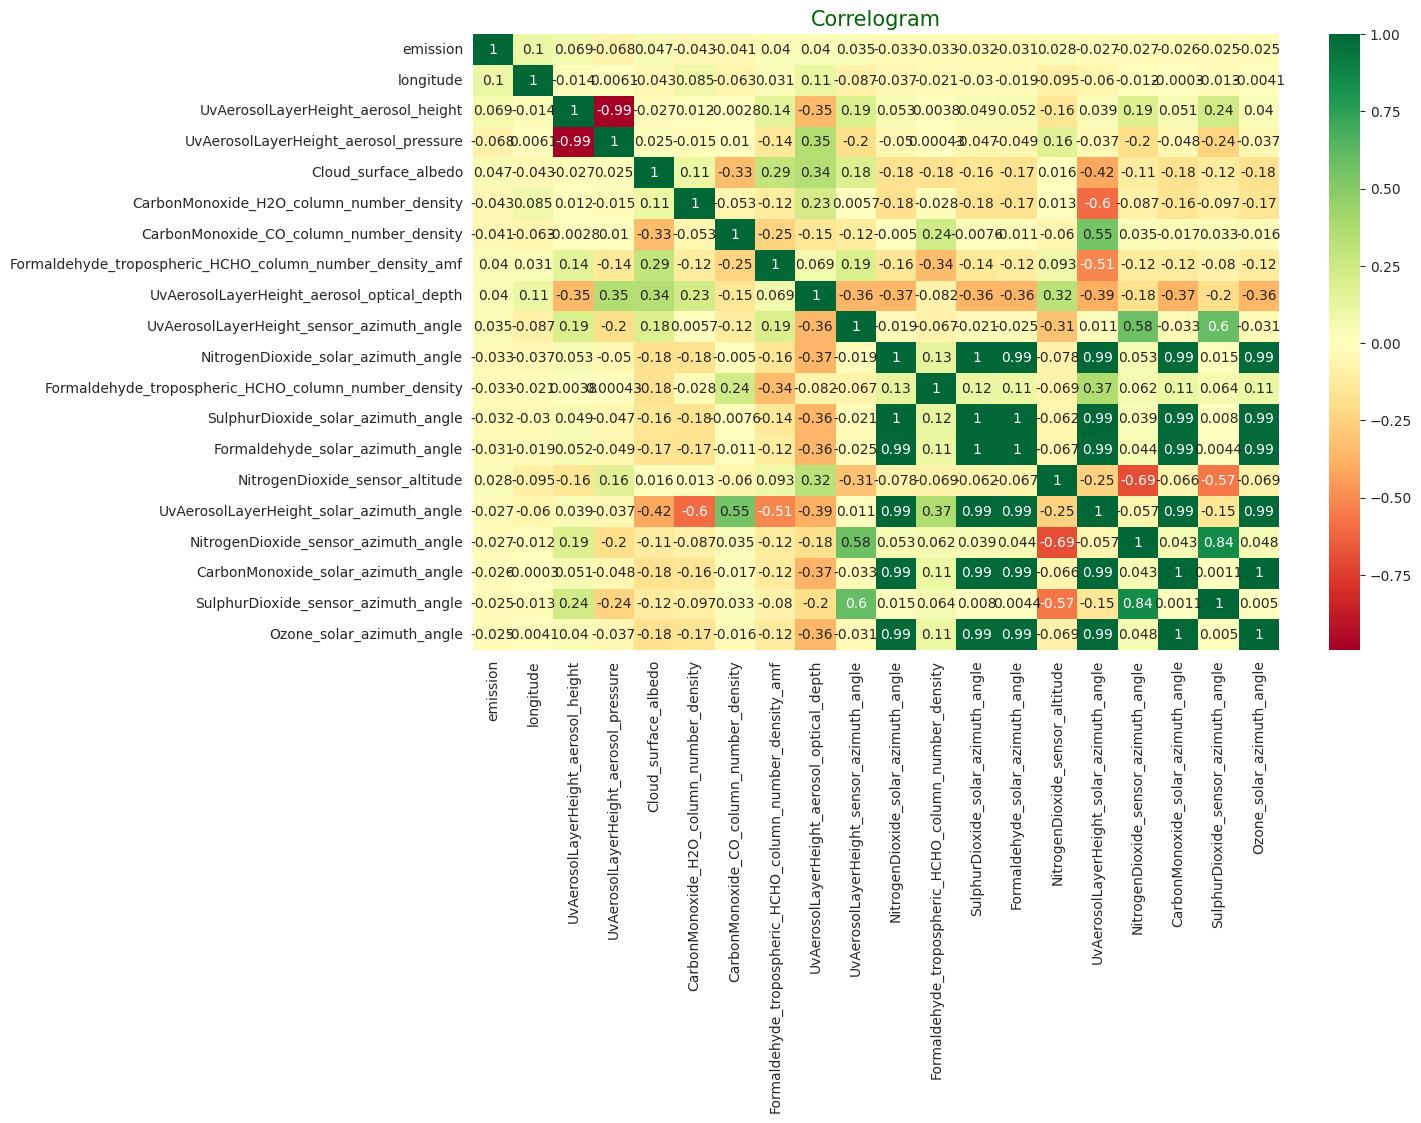

In [34]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

## 3.7. &nbsp; Emission Trend Over Year

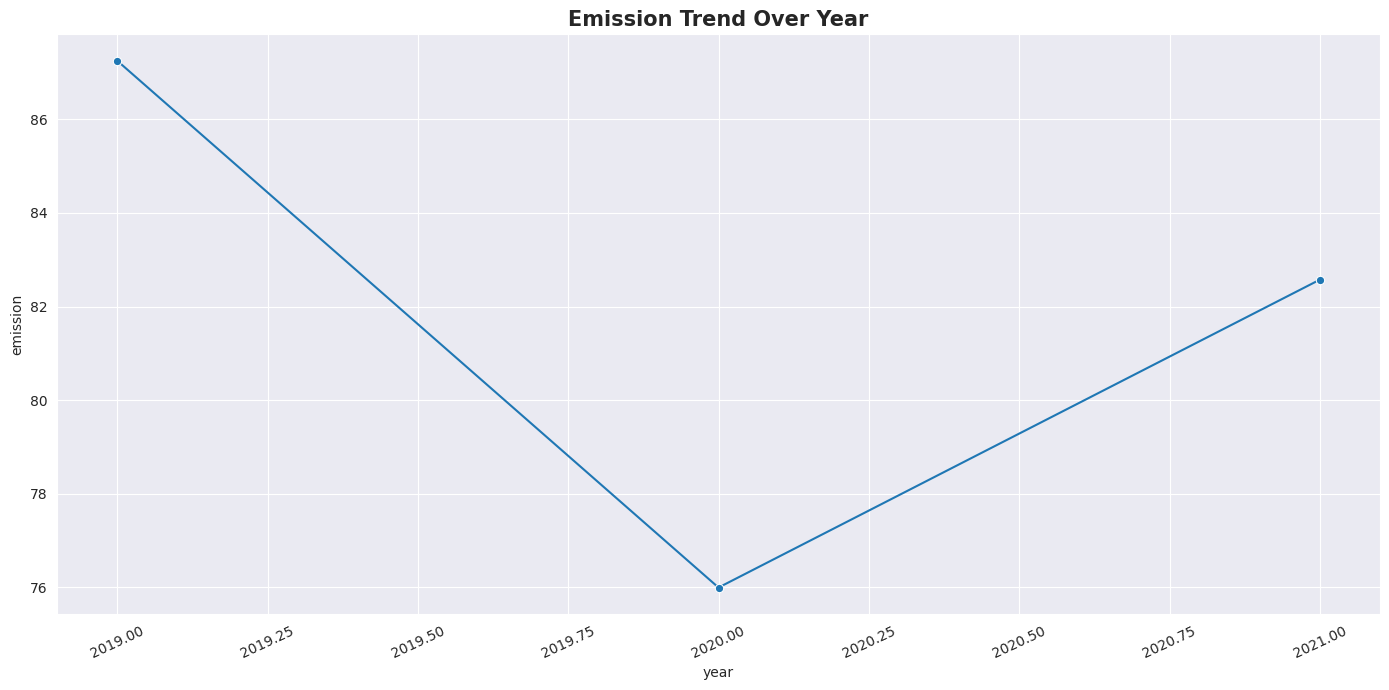

In [35]:
# Emission Trend Over Year
plt.figure(figsize=(14,7))
sns.lineplot(data = train_clean, x = 'year', y = 'emission',  marker='o',ci=None)
plt.title('Emission Trend Over Year', fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 25)
plt.grid(True)
plt.tight_layout()
plt.show()

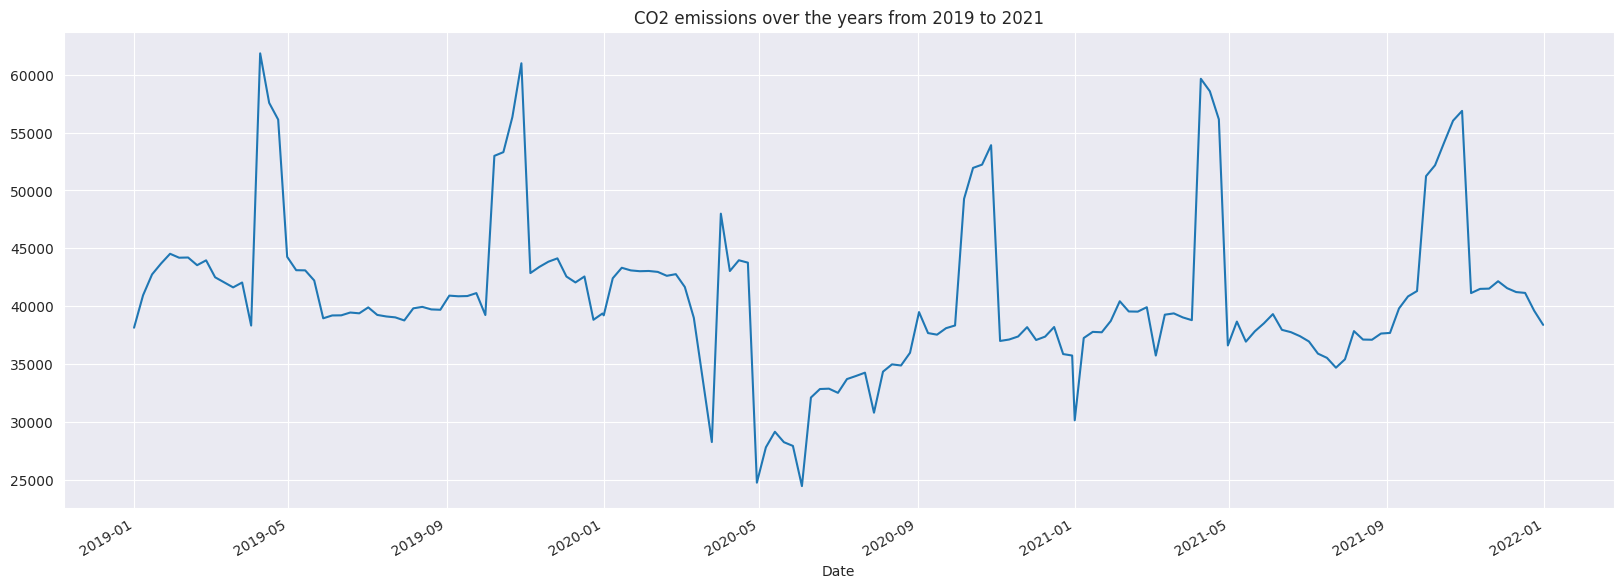

In [36]:
train_clean['date'] = pd.to_datetime(train_clean['year'], format="%Y") + pd.to_timedelta(train_clean['week_no'], unit="W")

train_clean.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
plt.title("CO2 emissions over the years from 2019 to 2021")
plt.show()

In [37]:
ratios = train_clean[train_clean['year'].isin((2019,2021))].groupby('week_no')['emission'].mean() / train_clean[(train_clean['year']==2020)].groupby('week_no')['emission'].mean()

train_clean.loc[train_clean['year'] == 2020, 'emission'] *= train_clean['week_no'].map(ratios)

In [38]:
train_clean['date'] = pd.to_datetime(train_clean['year'], format="%Y") + pd.to_timedelta(train_clean['week_no'], unit="W")
test_clean['date'] = pd.to_datetime(test_clean['year'], format="%Y") + pd.to_timedelta(test_clean['week_no'], unit="W")

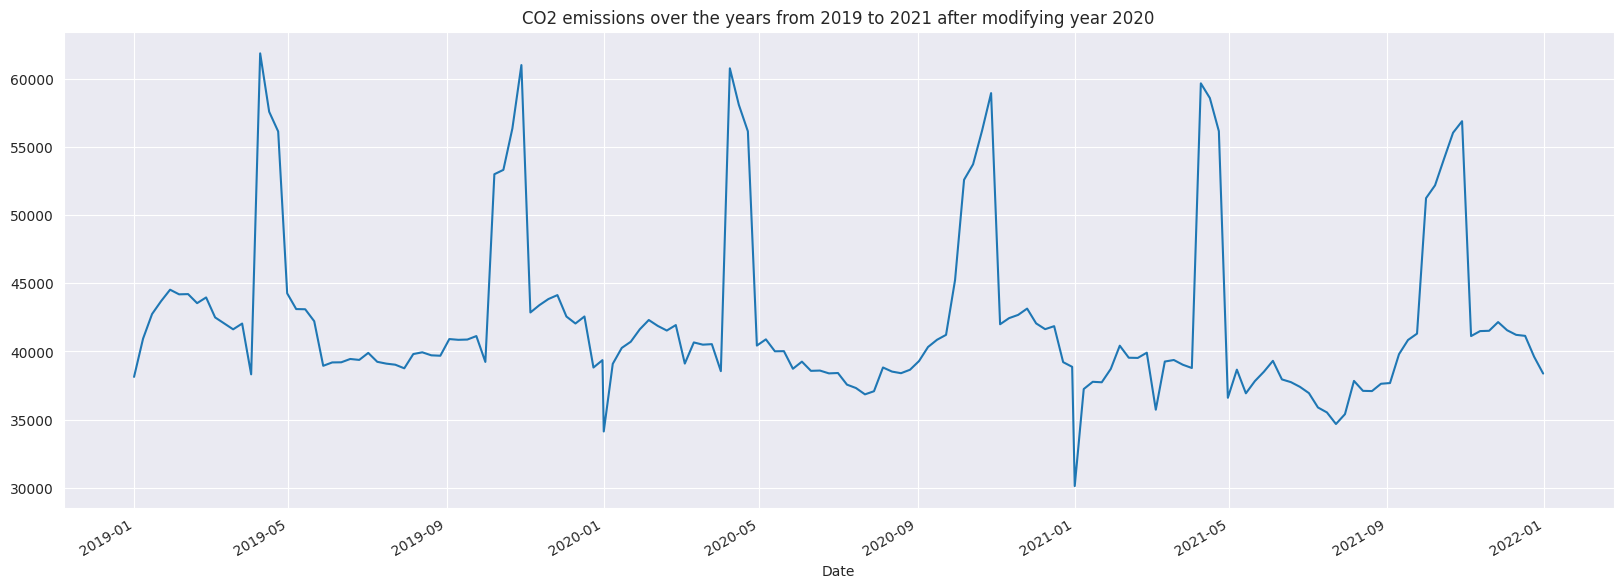

In [39]:
train_clean.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
plt.title("CO2 emissions over the years from 2019 to 2021 after modifying year 2020")
plt.show()

In [40]:
# The shape of the data after the cleaning and engineering process
(train_clean.shape, test_clean.shape)

((79023, 70), (24353, 69))

# 4.&nbsp; Feature Engineering

In [41]:
train_clean_eng = train_clean.copy()
test_clean_eng = test_clean.copy()

In [42]:
# helper method that gives a sine and cosine encoding for latitude, longtitude, month, and week_no
def sin_cos_encode(data, max_week_val):

    data_eng = data.copy()
    data_eng['latitude_sin'] = np.sin(np.radians(data['latitude']))
    data_eng['latitude_cos'] = np.cos(np.radians(data['latitude']))
    data_eng['longitude_sin'] = np.sin(np.radians(data['longitude']))
    data_eng['longitude_cos'] = np.cos(np.radians(data['longitude']))

    data_eng['month_sin'] = np.sin(2 * np.pi * (data['month'] / 12))
    data_eng['month_cos'] = np.cos(2 * np.pi * (data['month'] / 12))

    data_eng['week_no_sin'] = np.sin(2 * np.pi * (data['week_no'] / max_week_val))
    data_eng['week_no_cos'] = np.cos(2 * np.pi * (data['week_no'] / max_week_val))

    return data_eng

In [43]:
train_clean_eng["month"] = train_clean_eng["date"].apply(lambda x:int(x.strftime('%m')))
test_clean_eng["month"] = test_clean_eng["date"].apply(lambda x:int(x.strftime('%m')))

In [44]:
train_clean_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,date,month
0,ID_-0.510_29.290_2019_00,-0.51000,29.29000,2019,0,-0.00011,0.60302,-0.00007,0.25567,-98.59389,...,2615.12048,15.56853,0.27229,-12.62899,35.63242,-138.78642,30.75214,3.75099,2019-01-01,1
1,ID_-0.510_29.290_2019_01,-0.51000,29.29000,2019,1,0.00002,0.72821,0.00001,0.13099,16.59286,...,3174.57242,8.69060,0.25683,30.35938,39.55763,-145.18393,27.25178,4.02518,2019-01-08,1
2,ID_-0.510_29.290_2019_02,-0.51000,29.29000,2019,2,0.00051,0.74820,0.00038,0.11002,72.79584,...,3516.28267,21.10341,0.25110,15.37788,30.40182,-142.51954,26.19330,4.23138,2019-01-15,1
3,ID_-0.510_29.290_2019_03,-0.51000,29.29000,2019,3,0.00005,0.83485,0.00004,0.15842,-7.92587,...,4180.97332,15.38690,0.26204,-11.29340,24.38036,-132.66583,28.82915,4.30529,2019-01-22,1
4,ID_-0.510_29.290_2019_04,-0.51000,29.29000,2019,4,-0.00008,0.67630,-0.00005,0.12116,4.12127,...,3355.71011,8.11469,0.23585,38.53226,37.39298,-141.50981,22.20461,4.34732,2019-01-29,1


In [45]:
_max_week_val_train = max(train_clean_eng["week_no"])
_max_week_val_test = max(test_clean_eng["week_no"])

train_clean_eng = sin_cos_encode(train_clean_eng, _max_week_val_train)
test_clean_eng = sin_cos_encode(test_clean_eng, _max_week_val_test)

In [46]:
train_clean_eng["year_int"] = train_clean_eng["year"] - 2019
test_clean_eng["year_int"] = test_clean_eng["year"] - 2019

# 5.&nbsp; Modeling

In [47]:
# keep the year for now to filter the train-test set, and then drop it right after
train_features = ['year', 'year_int', 'latitude_sin', 'longitude_sin', 'latitude_cos',
                  'longitude_cos', 'week_no_sin', 'week_no_cos', 'month_sin', 'month_cos']
X = train_clean_eng[train_features]
y = train_clean_eng["emission"]

In [48]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

train_index = X.query('year in (2019,2020)').index
test_index = X.query('year == 2021').index

X_train = X.iloc[train_index].drop(columns=['year'])
y_train = y.iloc[train_index]
X_test = X.iloc[test_index].drop(columns=['year'])
y_test = y.iloc[test_index]

## 5.1.&nbsp; Model Selection

### 5.1.1 XGBoost Regresor

In [49]:
# Membuat model XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Memprediksi nilai pada data uji
xgb_pred = xgb_model.predict(X_test)

# Menghitung RMSE dan R-squared
rmse = mean_squared_error(y_test, xgb_pred, squared=False)
r2 = r2_score(y_test, xgb_pred)

print("XGB Regressor model")
print("\tRMSE = ", rmse)
print("\tR2 = ", r2)

XGB Regressor model
	RMSE =  20.303232261932422
	R2 =  0.9807843548321937


In [50]:
# Specify a new parameter grid
new_param_grid = {
    'max_depth': [5, 10, 15],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.1, 0.3, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 150, 200]
}

# Create the XGBoost model
xgb_model = XGBRegressor(random_state=SEED)

# Perform randomized search with the new parameter grid
from sklearn.model_selection import RandomizedSearchCV

random_search_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=new_param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=SEED,
    n_jobs=-1,
    verbose=2
)

random_search_xgb.fit(X_train, y_train)

# Print the best parameters
print("Best Hyperparameters for XGBoost:", random_search_xgb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'gamma': 0.1, 'colsample_bytree': 1.0}


In [51]:
# Best hyperparameters from the randomized search
best_hyperparameters = random_search_xgb.best_params_

# Create the XGBoost model with the best hyperparameters
best_xgb_model = XGBRegressor(**best_hyperparameters, random_state=SEED)

# Fit the model to the training data
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test data
xgb_pred = best_xgb_model.predict(X_test)

rmse = mean_squared_error(y_test, xgb_pred, squared=False)
r2 = r2_score(y_test, xgb_pred)

print("XGB Regressor model with Best Hyperparameter")
print("\tRMSE = ", rmse)
print("\tR2 = ", r2)

XGB Regressor model with Best Hyperparameter
	RMSE =  19.218850231072036
	R2 =  0.9827821305839906


### 5.1.2 Random Forest Regressor

#### 5.1.2.1 Model 1 (Tuning)

In [52]:
# Membuat model Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model1 = RandomForestRegressor(n_estimators=100, random_state=0)  # Ganti n_estimators sesuai kebutuhan
rf_model1.fit(X_train, y_train)

# Memprediksi nilai pada data uji
rf_pred = rf_model1.predict(X_test)

# Menghitung RMSE dan R-squared
rmse = mean_squared_error(y_test, rf_pred, squared=False)
r2 = r2_score(y_test, rf_pred)

print("Random Forest Regressor model:")
print("\tRMSE =", rmse)
print("\tR2 =", r2)

Random Forest Regressor model:
	RMSE = 17.69407521323953
	R2 = 0.9854057983412196


#### 5.1.2.2 Model 2 (Tuning)

In [53]:
# Membuat model Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model2 = RandomForestRegressor(n_estimators=100, max_features=1.0, min_samples_leaf=1, min_samples_split=2, random_state=0)  # Ganti n_estimators sesuai kebutuhan
rf_model2.fit(X_train, y_train)

# Memprediksi nilai pada data uji
rf_pred = rf_model2.predict(X_test)

# Menghitung RMSE dan R-squared
rmse = mean_squared_error(y_test, rf_pred, squared=False)
r2 = r2_score(y_test, rf_pred)

print("Random Forest Regressor model:")
print("\tRMSE =", rmse)
print("\tR2 =", r2)

Random Forest Regressor model:
	RMSE = 17.69407521323953
	R2 = 0.9854057983412196


#### 5.1.2.3 Model 3 (Tuning)

In [54]:
# Membuat model Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model3 = RandomForestRegressor(n_estimators=150, max_features=1.0, min_samples_leaf=3, min_samples_split=4, random_state=0)  # Ganti n_estimators sesuai kebutuhan
rf_model3.fit(X_train, y_train)

# Memprediksi nilai pada data uji
rf_pred = rf_model3.predict(X_test)

# Menghitung RMSE dan R-squared
rmse = mean_squared_error(y_test, rf_pred, squared=False)
r2 = r2_score(y_test, rf_pred)

print("Random Forest Regressor model:")
print("\tRMSE =", rmse)
print("\tR2 =", r2)

Random Forest Regressor model:
	RMSE = 16.830728090394704
	R2 = 0.9867952430328567


#### 5.1.2.4 Model 4 (Tuning)

In [55]:
# Membuat model Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model4 = RandomForestRegressor(n_estimators=200, max_features=1.0, min_samples_leaf=3, min_samples_split=4, random_state=0)  # Ganti n_estimators sesuai kebutuhan
rf_model4.fit(X_train, y_train)

# Memprediksi nilai pada data uji
rf_pred = rf_model4.predict(X_test)

# Menghitung RMSE dan R-squared
rmse = mean_squared_error(y_test, rf_pred, squared=False)
r2 = r2_score(y_test, rf_pred)

print("Random Forest Regressor model:")
print("\tRMSE =", rmse)
print("\tR2 =", r2)

Random Forest Regressor model:
	RMSE = 16.85942159849326
	R2 = 0.9867501809570044


#### 5.1.2.5 Model 5 (Tuning)

In [56]:
# Membuat model Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model5 = RandomForestRegressor(n_estimators=200, max_features=1.0, min_samples_leaf=5, min_samples_split=6, random_state=0)  # Ganti n_estimators sesuai kebutuhan
rf_model5.fit(X_train, y_train)

# Memprediksi nilai pada data uji
rf_pred = rf_model5.predict(X_test)

# Menghitung RMSE dan R-squared
rmse = mean_squared_error(y_test, rf_pred, squared=False)
r2 = r2_score(y_test, rf_pred)

print("Random Forest Regressor model:")
print("\tRMSE =", rmse)
print("\tR2 =", r2)

Random Forest Regressor model:
	RMSE = 17.88962237898112
	R2 = 0.9850814384057905


#### 5.1.2.6 Model 6 (MODEL YANG DIGUNAKAN)

In [57]:
# Membuat model Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model6 = RandomForestRegressor(n_estimators=100, max_features=1.0, min_samples_leaf=3, min_samples_split=4, random_state=0)  # Ganti n_estimators sesuai kebutuhan
rf_model6.fit(X_train, y_train)

# Memprediksi nilai pada data uji
rf_pred_use = rf_model6.predict(X_test)

# Menghitung RMSE dan R-squared
rmse = mean_squared_error(y_test, rf_pred_use, squared=False)
r2 = r2_score(y_test, rf_pred_use)

print("Random Forest Regressor model:")
print("\tRMSE =", rmse)
print("\tR2 =", r2)

Random Forest Regressor model:
	RMSE = 16.712906320848543
	R2 = 0.9869794729946432


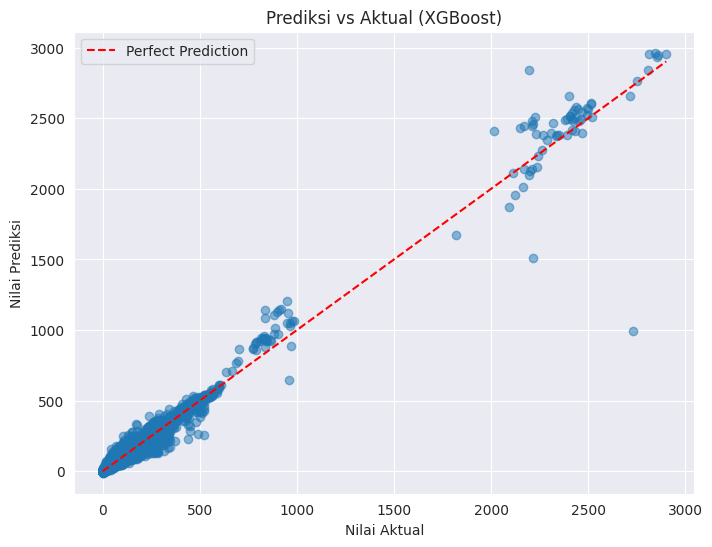

In [58]:
import matplotlib.pyplot as plt

# Membuat plot scatter
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xgb_pred, alpha=0.5)
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')
plt.title('Prediksi vs Aktual (XGBoost)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.legend()
plt.show()

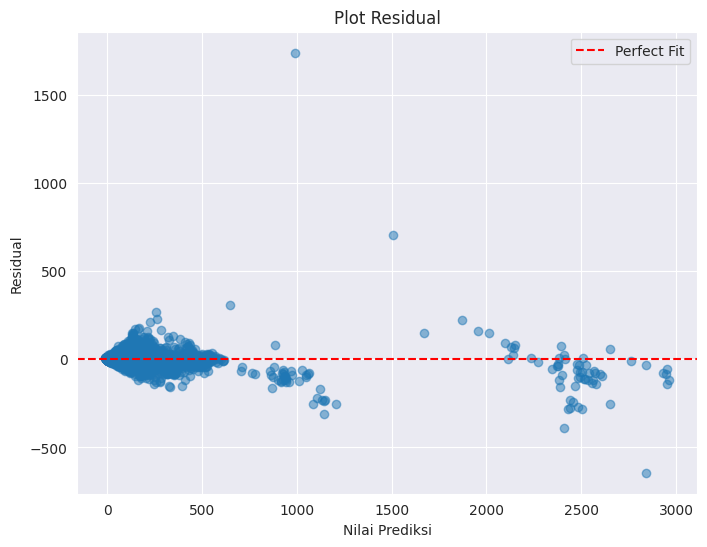

In [59]:
residuals = y_test - xgb_pred

plt.figure(figsize=(8, 6))
plt.scatter(xgb_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Perfect Fit')
plt.xlabel('Nilai Prediksi')
plt.ylabel('Residual')
plt.title('Plot Residual')
plt.legend()
plt.show()

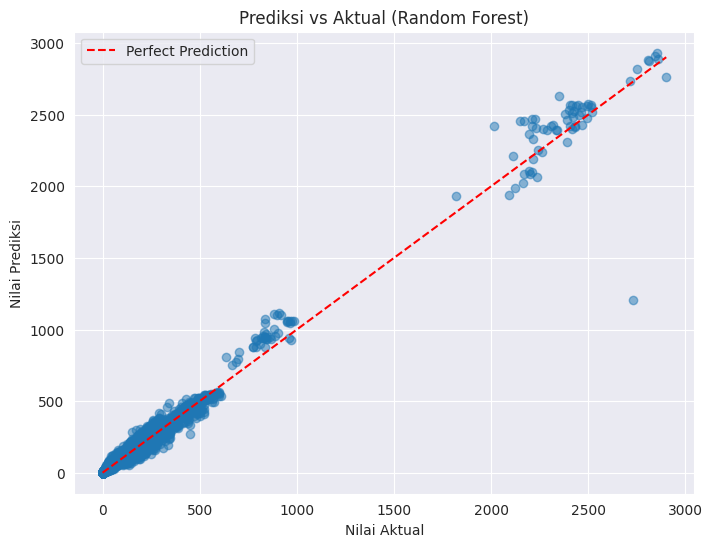

In [60]:
import matplotlib.pyplot as plt

# Membuat plot scatter
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_pred_use, alpha=0.5)
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')
plt.title('Prediksi vs Aktual (Random Forest)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.legend()
plt.show()

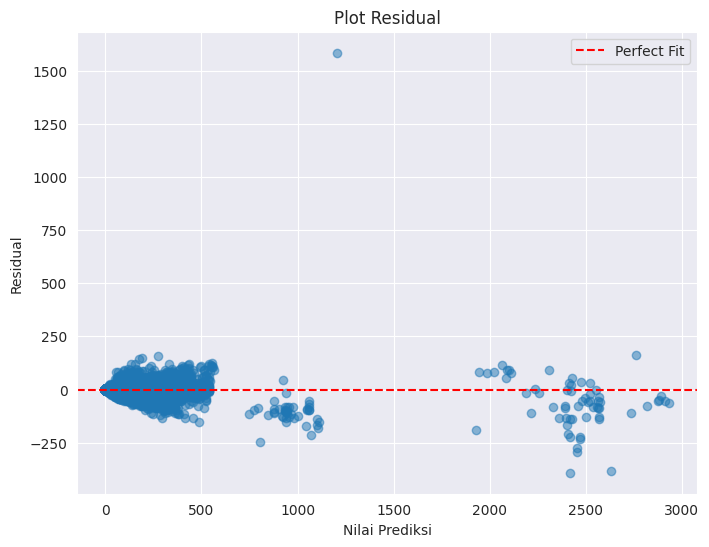

In [61]:
residuals = y_test - rf_pred

plt.figure(figsize=(8, 6))
plt.scatter(rf_pred_use, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Perfect Fit')
plt.xlabel('Nilai Prediksi')
plt.ylabel('Residual')
plt.title('Plot Residual')
plt.legend()
plt.show()

# 6.&nbsp; Making predictions of the test set and creating a submission file

In [62]:
# Make the prediction
X_test_final = test_clean_eng[train_features].drop(columns=['year']).to_numpy()

y_sub_pred = rf_model6.predict(X_test_final)
y_sub_pred

array([ 3.76236093,  3.88840448,  4.02955512, ..., 29.2744123 ,
       27.20801811, 27.02314786])

In [63]:
test_clean_eng['emission'] = y_sub_pred

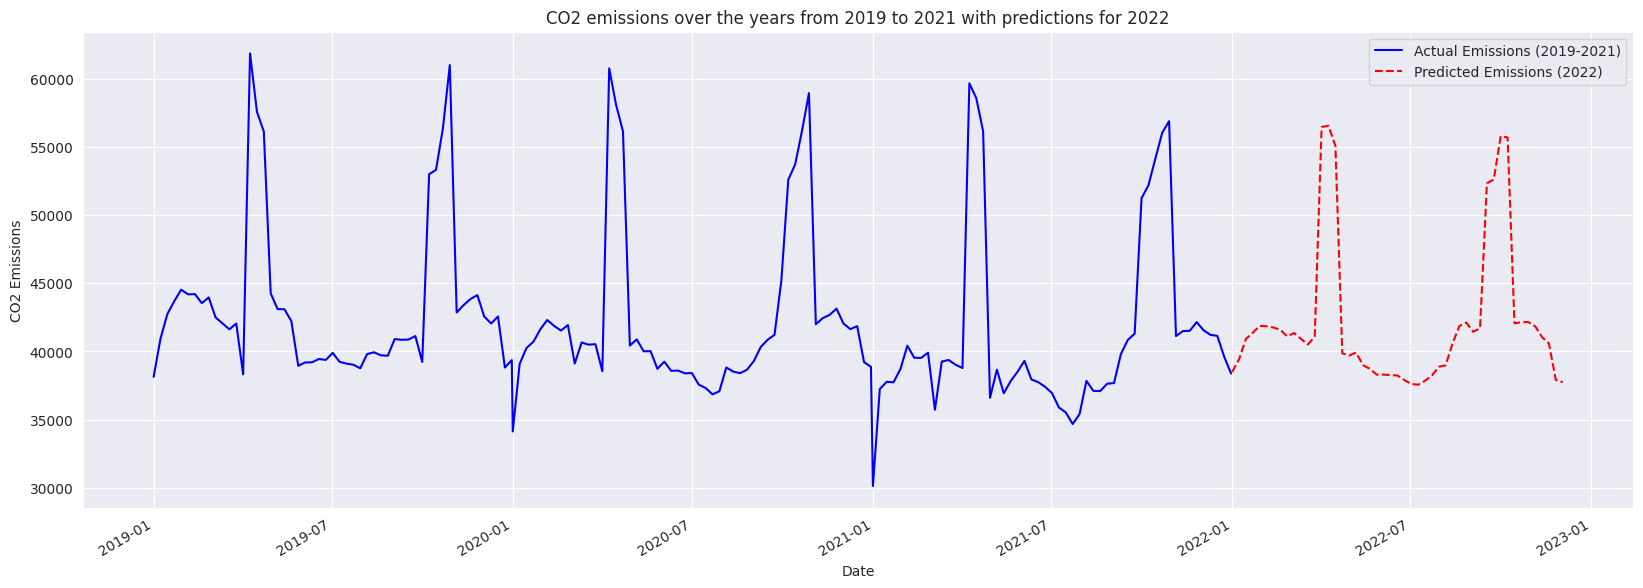

In [64]:
# Plot data historis dan prediksi
plt.figure(figsize=(20, 7))

# Plot data historis
train_clean_eng.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date', color='blue', label='Actual Emissions (2019-2021)')

# Plot data prediksi
test_clean_eng.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date', color='red', linestyle='--', label='Predicted Emissions (2022)')

plt.xlabel('Date')
plt.ylabel('CO2 Emissions')
plt.title("CO2 emissions over the years from 2019 to 2021 with predictions for 2022")
plt.legend()
plt.show()

In [65]:
# Create the submission file
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_clean_eng.ID_LAT_LON_YEAR_WEEK,
                           'emission': y_sub_pred })

# post-processing, fix the negative emission (which is not allowed) to 0
submission.loc[submission['emission'] < 0 , "emission"] = 0
submission['emission'] = submission['emission'].round(3)
submission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.76200
1,ID_-0.510_29.290_2022_01,3.88800
2,ID_-0.510_29.290_2022_02,4.03000
3,ID_-0.510_29.290_2022_03,4.08000
4,ID_-0.510_29.290_2022_04,4.11800


In [66]:
submission.sample(5)

,ID_LAT_LON_YEAR_WEEK,emission
2579,ID_-0.989_30.411_2022_31,39.71200
13868,ID_-2.049_30.751_2022_01,45.96900
13020,ID_-1.944_28.556_2022_35,6.36200
3070,ID_-1.043_29.057_2022_32,11.71800
4528,ID_-1.170_29.330_2022_20,0.31200


In [67]:
submission.tail(10)

,ID_LAT_LON_YEAR_WEEK,emission
24343,ID_-3.299_30.301_2022_39,29.82200
24344,ID_-3.299_30.301_2022_40,30.01400
24345,ID_-3.299_30.301_2022_41,29.89400
24346,ID_-3.299_30.301_2022_42,29.95500
24347,ID_-3.299_30.301_2022_43,29.94300
24348,ID_-3.299_30.301_2022_44,30.04000
24349,ID_-3.299_30.301_2022_45,29.46600
24350,ID_-3.299_30.301_2022_46,29.27400
24351,ID_-3.299_30.301_2022_47,27.20800
24352,ID_-3.299_30.301_2022_48,27.02300


In [68]:
# Save the submission file to working folder
submission.to_csv('submission.csv', index = False)

# 7.&nbsp; Saving The Trained Model for Deployment

In [69]:
import pickle

In [70]:
filename = 'emission_model.sav'
pickle.dump(rf_model6, open(filename, 'wb'))

In [71]:
# loading the saved model
loaded_model = pickle.load(open('emission_model.sav', 'rb'))